<a href="https://colab.research.google.com/github/RashaAlshawi/EFPN/blob/main/EFPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Enhanced Feature Pyramid Network (E-FPN)**

The E-FPN is a deep learning model designed for semantic segmentation in imbalanced datasets, particularly for infrastructure inspection tasks like detecting defects in culverts and sewer pipes. It incorporates architectural innovations such as sparsely connected blocks and depth-wise separable convolutions to improve feature extraction. Experimental results show that E-FPN outperforms state-of-the-art methods, with an average 16.2% IoU improvement on the culvert-sewer dataset and 27.2% IoU improvement on a benchmark aerial dataset.

In [ ]:
#@title Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, SeparableConv2D,MaxPooling2D, concatenate, Conv2DTranspose,  BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, initializers,layers
import math
import numpy as np
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras import backend as K
import datetime
from keras.utils import to_categorical
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
!pip install pyyaml h5py  # Required to save models in HDF5 format
from keras.models import load_model

#import tensorflow_addons as tfa

#Blocks

In [2]:
activation_=tf.keras.activations.relu
def conv_block(inputs, filters, kernel_size=(3, 3), padding='same', activation=activation_):
    conv = layers.SeparableConv2D(filters, kernel_size, padding=padding)(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = activation(conv)
    return conv

In [3]:
#Depth Wise Separable Block
def inception_sepconvblock(inputs, f1, f2, f3):
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(inputs)
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(conva)

    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(inputs)
    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(convb)

    convc = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    convc = Conv2D(f3, (1, 1), padding='same')(convc)

    concatenated = concatenate([conva, convb, convc])
    print(concatenated.shape)

    return concatenated

In [4]:
#@title Base Enhanced Feature Pyramid Network (EFPN)
def build_fpn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    # Bottom-up pathway
    conv1 = inception_sepconvblock(inputs, f1=22, f2=21, f3=21)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = inception_sepconvblock(pool1, f1=44, f2=42, f3=42)  # 128x128
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = inception_sepconvblock(pool2, f1=86, f2=85, f3=85)  # 64x64
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = inception_sepconvblock(pool3, f1=171, f2=171, f3=170)  # 32x32
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = inception_sepconvblock(pool4, f1=342, f2=341, f3=341)  # 16x16

    # Top-down pathway
    p5 = conv_block(conv5, 128, kernel_size=(1, 1))  # Reduce channel depth of conv5
    p4 = conv_block(conv4, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p5)
    p3 = conv_block(conv3, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p4)  # Upsampling factor adjusted
    p2 = conv_block(conv2, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p3)  # Upsampling factor adjusted

    # Prediction heads
    output_p3 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p3)
    output_p4 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p4)
    output_p5 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p5)
    output_p2 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p2)

    # Final prediction merging
    output1 = tf.keras.layers.UpSampling2D(size=(2, 2))(output_p2)+tf.keras.layers.UpSampling2D(size=(4, 4))(output_p3)+ tf.keras.layers.UpSampling2D(size=(8, 8))(output_p4) + tf.keras.layers.UpSampling2D(size=(16, 16))(output_p5)
    output = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(output1)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model


In [5]:
num_classes=9
input_shape = (128, 128, 3)

In [6]:
model = build_fpn(input_shape, num_classes)
#model.summary()

(None, 128, 128, 64)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)


#Load and Compile

In [7]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              #metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
              #,run_eagerly=True

              ) #tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(),


In [9]:
#@title Load Culver-Sewer Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
X_P=np.load('/content/drive/MyDrive/VideoFrames/PositiveImageNew.npy')
y_P=np.load('/content/drive/MyDrive/VideoFrames/PositivemaskNew.npy')

In [11]:
X_datas, y_datas = shuffle(X_P, y_P, random_state=10)

In [12]:
#all
numClasses=9
train_masks_cat = to_categorical(y_datas, num_classes=numClasses)
y_train_cat_test = train_masks_cat.reshape((y_datas.shape[0], y_datas.shape[1], y_datas.shape[2], numClasses))

In [13]:
#@title Dataset Normalization
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image
X_datas_=normalize(X_datas)

In [14]:
# Preparing The data for The Base Adaptive-FPN
samples_train = int(0.7 * len(X_datas_))
samples_val = int(0.15 * len(X_datas_))

X_train = X_datas_[:samples_train]
y_train = y_train_cat_test[:samples_train]

X_val = X_datas_[samples_train:samples_train + samples_val]
y_val = y_train_cat_test[samples_train:samples_train + samples_val]

X_test = X_datas_[samples_train + samples_val:]
y_test = y_train_cat_test[samples_train + samples_val:]

In [23]:
#@title  Model Training and Evaluation
filepath='/content/drive/MyDrive/best.h5'

In [21]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [24]:
my_callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=10),
              tf.keras.callbacks.ModelCheckpoint(
                   filepath,save_best_only=True,monitor='val_loss'),
                  tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]

In [ ]:
%tensorboard --logdir log

In [16]:
#Training EFPN
history=model.fit(x=[X_train],y=y_train,epochs=100,validation_data=([X_val], y_val),batch_size=5)#,callbacks=my_callbacks)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(5, 128, 128, 3))',)
  warnings.warn(msg)


704/707 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1-score: 0.6188 - iou_score: 0.6158 - loss: 0.9109

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 128, 128, 3))',)
  warnings.warn(msg)


707/707 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - f1-score: 0.6190 - iou_score: 0.6160 - loss: 0.9089 - val_f1-score: 0.6600 - val_iou_score: 0.6561 - val_loss: 0.3563
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - f1-score: 0.6547 - iou_score: 0.6504 - loss: 0.3772 - val_f1-score: 0.6601 - val_iou_score: 0.6561 - val_loss: 0.3246
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - f1-score: 0.6526 - iou_score: 0.6480 - loss: 0.3132 - val_f1-score: 0.6313 - val_iou_score: 0.6267 - val_loss: 0.2809
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - f1-score: 0.6392 - iou_score: 0.6292 - loss: 0.2652 - val_f1-score: 0.6630 - val_iou_score: 0.6557 - val_loss: 0.2610
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - f1-score: 0.6559 - iou_score: 0.6414 - loss: 0.2258 - val_f1-score: 0.5163 - val_iou_score: 0.5043 - val_loss: 0.3179
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - f1-score: 0.6894 - iou_score: 0.6739 - loss: 0.1899 - val_f1-score: 0.6898 - val

<Axes: >

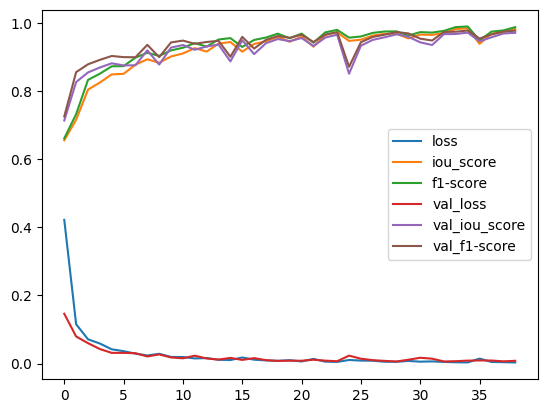

In [ ]:
c=pd.DataFrame(history.history)
c.plot() #

In [32]:
# Save the model
model.save('/content/drive/MyDrive/VideoFrames/DS/EFPNFeb5.h5')


In [ ]:
# Load the trained model
model = tf.keras.load_model(filepath+".h5",compile=True)

In [34]:
model.evaluate(X_test, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - f1-score: 0.8676 - iou_score: 0.8039 - loss: 0.0908


[0.09197129309177399, 0.7973897457122803, 0.8631768822669983]

In [18]:
y_predict=model.predict([X_test])

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 128, 128, 3))',)
  warnings.warn(msg)


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 411ms/step


In [19]:
y_predict_=np.argmax(y_predict, axis=-1)

In [20]:
y_test_=np.argmax(y_test, axis=3)

# Metrics- Model Evaluation



In [21]:
# Frequency Weighted Intersection over Union
def calculate_fwiou(predicted_mask, ground_truth_mask, class_frequencies):

    predicted_flat = K.flatten(predicted_mask)
    ground_truth_flat = K.flatten(ground_truth_mask)

    unique_classes = np.unique(ground_truth_flat)

    intersection_sum = 0
    union_sum = 0

    for class_val in unique_classes:
        class_mask = K.equal(ground_truth_flat, class_val)
        intersection = K.sum(K.cast(predicted_flat[class_mask] == class_val, K.floatx()))
        union = K.sum(K.cast((predicted_flat == class_val) | class_mask, K.floatx()))
        frequency = class_frequencies[class_val]

        intersection_sum += frequency * intersection
        union_sum += frequency * union

    fwiou = intersection_sum / union_sum

    return fwiou


In [22]:
class_frequencies = {0: 0.0,
                    1: 1, # crack
                     2: 1, # Hole
                     3: 1, #root
                     4: 0.1622,#deformation
                     5:0.7100 , #fracture
                     6: 0.3518, #erosion
                     7: 0.6419, #joints
                     8: 0.5419 #loose gasket
                     }

In [23]:

fwiou = calculate_fwiou(y_predict_, y_test_, class_frequencies)#0.7686044573783875
print(f"FWIoU: {fwiou}")

FWIoU: 0.784674346446991


In [26]:
# Calculate the F1 score for each unique class separately
y_true_flat = y_test_.flatten()
y_pred_flat = y_predict_.flatten()

unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
f1_scores = {}
for class_value in unique_classes:
    binary_y_true = (y_true_flat == class_value)
    binary_y_pred = (y_pred_flat == class_value)
    f1_scores[class_value] = f1_score(binary_y_true, binary_y_pred)

# F1 scores for each class
for class_value, f1_score_value in f1_scores.items():
    print(f"F1 Score for class {class_value}: {f1_score_value}")
# average f1_scores for all classes
average_F1_all = np.mean(list(f1_scores.values()))
print(f"Average f1_scores (including class 0): {average_F1_all}")
# average f1_scores excluding class 0
F1_scores_without_class_0 = {k: v for k, v in f1_scores.items() if k != 0}
average_F1_without_class_0 = np.mean(list(F1_scores_without_class_0.values()))
print(f"Average F1 (excluding class 0): {average_F1_without_class_0}")

F1 Score for class 0: 0.9895007376213135
F1 Score for class 1: 0.6914955754796881
F1 Score for class 2: 0.9847028467417708
F1 Score for class 3: 0.9390314027409513
F1 Score for class 4: 0.8911781499809669
F1 Score for class 5: 0.72172388286668
F1 Score for class 6: 0.8495266140492047
F1 Score for class 7: 0.8684365400731178
F1 Score for class 8: 0.8596525886519819
Average f1_scores (including class 0): 0.866138704245075
Average F1 (excluding class 0): 0.8507184500730451


In [27]:
# Calculate the IoU for each unique class separately
y_true_flat = y_test_.flatten()
y_pred_flat = y_predict_.flatten()
unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
iou_scores = {}
for class_value in unique_classes:
    intersection = np.sum((y_true_flat == class_value) & (y_pred_flat == class_value))
    union = np.sum((y_true_flat == class_value) | (y_pred_flat == class_value))

    iou_scores[class_value] = intersection / union
# IoU scores for each class
for class_value, iou_score in iou_scores.items():
    print(f"IoU for class {class_value}: {iou_score}")

# average IoU for all classes
average_iou_all = np.mean(list(iou_scores.values()))
print(f"Average IoU (including class 0): {average_iou_all}")

# average IoU excluding class 0
iou_scores_without_class_0 = {k: v for k, v in iou_scores.items() if k != 0}
average_iou_without_class_0 = np.mean(list(iou_scores_without_class_0.values()))
print(f"Average IoU (excluding class 0): {average_iou_without_class_0}")


IoU for class 0: 0.9792196535523015
IoU for class 1: 0.5284625428249394
IoU for class 2: 0.9698666479874616
IoU for class 3: 0.8850699305963295
IoU for class 4: 0.8037162597090504
IoU for class 5: 0.5646071871273227
IoU for class 6: 0.7384148337748148
IoU for class 7: 0.7674660510239816
IoU for class 8: 0.7538514842908938
Average IoU (including class 0): 0.7767416212096773
Average IoU (excluding class 0): 0.7514318671668492


In [28]:

def calculate_pixel_acc(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "Input arrays must have the same shape."

    total_pixels = np.prod(y_true.shape)
    correct_pixels = np.sum(y_true == y_pred)

    pixel_acc = correct_pixels / total_pixels

    return pixel_acc


In [29]:
pixel_acc = calculate_pixel_acc(y_test_, y_predict_)
print("Pixel Accuracy:", pixel_acc)

Pixel Accuracy: 0.9798456124166255


In [30]:
def calculate_balanced_accuracy(y_true, y_pred):
    unique_classes = np.unique(y_true)
    num_classes = 9

    class_accuracies = []

    for cls in unique_classes:
        true_mask = (y_true == cls)
        pred_mask = (y_pred == cls)

        class_accuracy = np.sum(true_mask & pred_mask) / np.sum(true_mask)
        class_accuracies.append(class_accuracy)

    balanced_acc = np.mean(class_accuracies)
    return balanced_acc
calculate_balanced_accuracy(y_test_, y_predict_)

0.84153123233044

In [31]:

#  Matthews correlation coefficient (MCC)
num_samples, height, width = y_test_.shape
num_classes = 9

# Reshape the arrays to 1D (num_samples * height * width,)
y_true_flat = y_test_.ravel()
y_pred_flat = y_predict_.ravel()

# Calculate  MCC for each class
mcc_scores = []
for class_idx in range(num_classes):
    class_true = (y_true_flat == class_idx)
    class_pred = (y_pred_flat == class_idx)
    mcc = matthews_corrcoef(class_true, class_pred)
    mcc_scores.append(mcc)

# Calculate  average MCC across all classes
mean_mcc = np.mean(mcc_scores)
mean_mcc

0.8527062091749659

In [ ]:
#@title Visual Results

In [ ]:
# Define the mapping of object colors to RGB values based on NASSCO’S PIPELINE Structural Color Coding
color_map = {
    0: [0, 0, 0],        # Background color
    1: [192, 209, 249],  # crack
    2: [191, 191, 191],  # hole
    3: [254, 255, 126],  # root
    4: [247, 205, 160],  # Deformation
    5:[246,202,255],  # Fracture
    6: [139, 2, 223],  # Erosion
    7: [188, 252, 176],  # joints
    8: [243,172,0] #loose_gasket

}

ALlFIveFeatuesofHaar 88


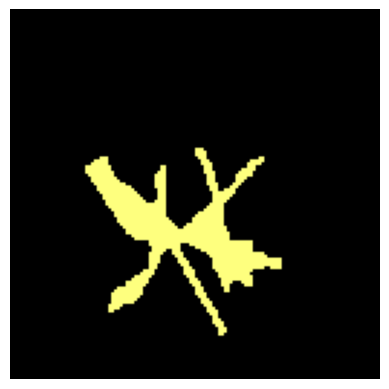

In [ ]:
#Sampels: 10, 20, 26, 50, 57, 88, 83
#samples: 199, 78,1,3,26, 50,88
i=88
print('ALlFIveFeatuesofHaar',i)
image = y_predict_[i]
# Map the object colors to RGB colors
rgb_imageP = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_imageP[i, j] = color_map[image[i, j]]
plt.axis('off')
plt.imshow(rgb_imageP);

Real: 3
[0 7]


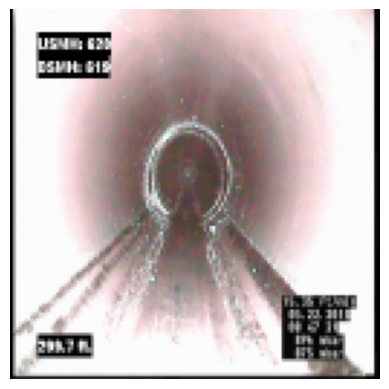

 Ground truth: 127


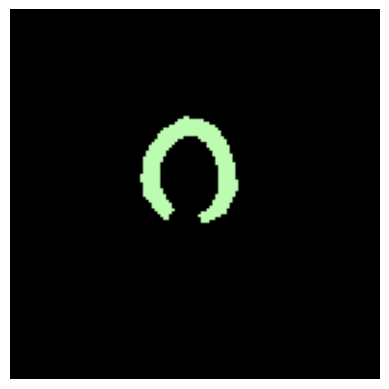

In [ ]:
i=3
image = y_test_[i]
print('Real:',i)
plt.axis('off')
plt.imshow(X_test[i])
print(np.unique( y_test_[i]))
plt.show()
# Map the object colors to RGB colors
rgb_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_image[i, j] = color_map[image[i, j]]

print(' Ground truth:',i)
plt.axis('off')
plt.imshow(rgb_image)

In [ ]:
label_mapping = {
    'background': 0,
    'crack': 1,
    'spiral_crack': 1,
    'hole': 2,
    'root': 3,
    'roots': 3,
    'Pipe_Deformed': 4,
    'deformation': 4,
     'fracture': 5,
    'erosion': 6,
     'encrustation': 6,
    'joint': 7,'joints':7,
    'joint_offset':7,'offset':7,
     'loose_gasket':8
}
